In [1]:
import matplotlib.pyplot as plt
import os
import torch 
from torch.utils.data import DataLoader
import json
import sys
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from data_class import SongDataSet_Image, CollateFunction
from model import TweetyBERT
from analysis import plot_umap_projection
from utils import detailed_count_parameters, load_weights, load_model


weights_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/experiments/llb3_train_500/saved_weights/model_step_19998.pth"
config_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/experiments/llb3_train_500/config.json"

tweety_bert_model = load_model(config_path, weights_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/george-vengrovski/anaconda3/envs/canary-vae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Class

In [3]:
from torch.utils.data import DataLoader
from data_class import SongDataSet_Image

train_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_train_25"
test_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/llb3_test_25"

train_dataset = SongDataSet_Image(train_dir, num_classes=21, psuedo_labels_generated=False)
test_dataset = SongDataSet_Image(test_dir, num_classes=21, psuedo_labels_generated=False)

collate_fn = CollateFunction(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

## Define Linear Classifier and Train

In [6]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

classifier_model = LinearProbeModel(num_classes=21, model_type="neural_net", model=tweety_bert_model, freeze_layers=True, layer_num=-1, layer_id="attention_output", classifier_dims=196)
classifier_model = classifier_model.to(device)

Batch 100: FER = 6.50%, Train Loss = 0.2612, Val Loss = 0.2253
Batch 200: FER = 5.91%, Train Loss = 0.1608, Val Loss = 0.1934
Batch 300: FER = 5.56%, Train Loss = 0.1572, Val Loss = 0.1788
Batch 400: FER = 5.27%, Train Loss = 0.1840, Val Loss = 0.1673
Batch 500: FER = 5.40%, Train Loss = 0.1696, Val Loss = 0.1719
Batch 600: FER = 5.12%, Train Loss = 0.2097, Val Loss = 0.1609
Batch 700: FER = 5.37%, Train Loss = 0.1590, Val Loss = 0.1723
Batch 800: FER = 4.76%, Train Loss = 0.1698, Val Loss = 0.1498
Batch 900: FER = 4.55%, Train Loss = 0.1618, Val Loss = 0.1432
Batch 1000: FER = 4.98%, Train Loss = 0.1435, Val Loss = 0.1548
Batch 1100: FER = 4.78%, Train Loss = 0.1173, Val Loss = 0.1474
Batch 1200: FER = 4.90%, Train Loss = 0.1650, Val Loss = 0.1538
Batch 1300: FER = 4.73%, Train Loss = 0.1327, Val Loss = 0.1476
Early stopping triggered


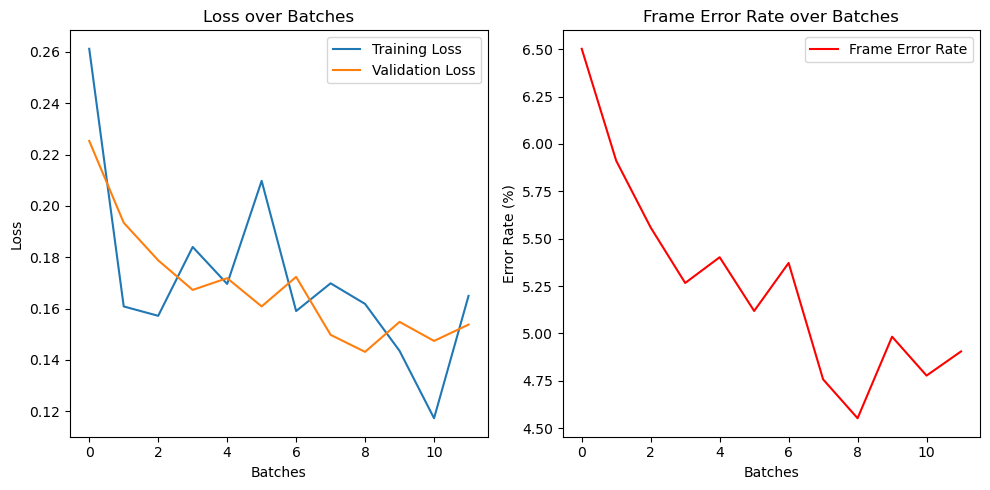

In [7]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=100, desired_total_batches=1e4, patience=4)
trainer.train()

## Analyze

In [5]:
from linear_probe import ModelEvaluator

evaluator = ModelEvaluator(classifier_model, test_loader)
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, '/home/george-vengrovski/Documents/projects/tweety_bert_paper/results/test')

Evaluating: 100%|██████████| 538/538 [00:23<00:00, 23.30batch/s]
